# Predicting Red Wine Quality
## Phase 2: Predictive Modeling
### Group 25
### Galen Ralph Herten-Crabb 3955778 
---

### Contents

* [Introduction](#intro)
    * [Phase 1 Summary](#summary)
    * [Report Overview](#report_overview)
    * [Overview of Methodology](#methodology)
* [Predictive Modelling](#modeling)
    * [Feature Selection](#FS)
    * [Model Fitting & Tuning](#fit)
    * [Model Comparison](#comparison)
* [Critique & Limitations](#critique)
* [Summary & Conclusions](#con)
    * [Project Summary](#PS)
    * [Summary of Findings](#find)
    * [Conclusions](#cons)
* [References](#references)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from scipy import stats

## Introduction <a id = 'intro'></a>
The goal of this project is to determine the quality of red wine from the collated quantities of its chemical characteristics before it is assessed by tasters or the market. Specifically, this report seeks to reliably detect high quality wine over lower qualities so that a vintner or merchant may predict sales price, and therefore ROI or change agricultural processes ahead of time to ensure the optimal balance. Put simply the aim is.
1. Predict the quality of red wine e.g., predict whether red wine is of a high or low quality.
2. Identify the chemical features and/or combination of features that determine red wine quality. 



### Phase 1 Summary <a id = 'summary'></a>

The dataset for this project is sourced from the University of California, School of Information and Computer Science Machine Learning Repository (Cortez et al., 2009). Its contents pertain to the quantitative chemical characteristics and qualitative assessments of nearly 1600 different red wines of the Portuguese "Vinho Verde" varietal. The first phase consisted of many pre-processing and exploration steps, including the selection of a target feature, and the identification of some possibly key descriptive features. The goal, as stated above, is to successfully predict the quality of red wine from the analysis of its chemical components and quantities, this will be achieved by using ML algorithms to predict the ‘Quality’ variable from the dataset, this variable is out target.

During the pre-processing phase, few cleaning measures were required as the dataset came in excellent condition with no missing or special values. The only technique used to prepare the data was to remove the spaces from the headers and replace them with underscores.

Data visualisations were then employed to further an understanding of the variables and their characteristics. The alcohol and citric acid variables were tested for correlation and were found to be strong indicators of quality, although not absolutely and within limits. It was concluded that low alcohol combined with low citric acid were indicative of poor-quality red wine but that these quantities in reverse were no guarantee of the opposite.




### Report Overview <a id = 'report_overview'></a>

Phase 2 shall consist of fitting exactly three different algorithms to our data to determine the most accurate model. This process begins with feature selection and then proceeds to fit the different models to the data while tuning them to optimal levels, or at least to as optimal a level as each model can achieve. The models will be compared, and their respective strengths critiqued. Following these steps, will be a thorough examination of the methods used ending in a summary of the entire project including any conclusions regarding results and the specific issues encountered on the way to achieving this project’s goal.

A note on the target variable. In the original dataset the quality column represented the target but as this report is concerned with the detection of high-quality wines that variable has been categorised into two measures. Namely, Low_Quality - defined as having a score between 3 and 6, and High_Quality - defined as having a quality score of either 7 or 8. The range of the quality variable is only between 3 and 8 as each score represents the mean of three separate tastings marked out of 10.


In [2]:
df = pd.read_csv('winequality-red.csv', sep=';') #read in the data
df.columns = df.columns.map(lambda x : x.replace("-", "_").replace(" ", "_")) #snake the headers 
df['target'] = pd.cut(x=df['quality'], bins=[3, 6, 8,], labels=['Low_Quality', 'High_Quality']) #bin the target 
df = df.drop(['quality'], axis=1) #drop original target 'quality'
df.sample(10, random_state=9999)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,target
797,9.3,0.370,0.44,1.6,0.038,21.0,42.0,0.99526,3.24,0.81,10.8,High_Quality
1332,8.4,0.390,0.10,1.7,0.075,6.0,25.0,0.99581,3.09,0.43,9.7,Low_Quality
152,7.5,0.600,0.03,1.8,0.095,25.0,99.0,0.99500,3.35,0.54,10.1,Low_Quality
1426,7.7,0.230,0.37,1.8,0.046,23.0,60.0,0.99710,3.41,0.71,12.1,Low_Quality
38,5.7,1.130,0.09,1.5,0.172,7.0,19.0,0.99400,3.50,0.48,9.8,Low_Quality
75,8.8,0.410,0.64,2.2,0.093,9.0,42.0,0.99860,3.54,0.66,10.5,Low_Quality
1211,6.6,0.440,0.15,2.1,0.076,22.0,53.0,0.99570,3.32,0.62,9.3,Low_Quality
154,7.1,0.430,0.42,5.5,0.070,29.0,129.0,0.99730,3.42,0.72,10.5,Low_Quality
1549,7.4,0.360,0.30,1.8,0.074,17.0,24.0,0.99419,3.24,0.70,11.4,High_Quality
901,7.4,0.635,0.10,2.4,0.080,16.0,33.0,0.99736,3.58,0.69,10.8,High_Quality


In [3]:
df['target'].value_counts()

Low_Quality     1372
High_Quality     217
Name: target, dtype: int64

### Overview of Methodology <a id = 'methodology'></a>

As the problem involves classifying a binary target this reports strategy shall involve the use of Decision Trees, K-Nearest Neighbours and Gaussian Naive Bayes classifiers. The data shall endure further processing in the form of encoding the categorical target into numerical values (0 & 1) and the scaling of all descriptive variables before being divided into test and train sets at a ratio of 70:30

Feature selection shall occur, utilising the F-Score classification method, but the initial phase of fitting shall use the entire suite of variables to explore all possible relationships. This fitting process will include using grid search cross validation to fine tune the parameters along with the Repeated Stratified K-Fold validator.  After this initial, full set  fitting process the models shall be compared, this time with feature selection built into pipelines designed to assess each algorithm using the afore mentioned cross validation techniques again.

The final examination, once optimal hyper-parameter values have been determined, is paired t-tests to determine if performance difference is statistically significant or not. 

## Predictive Modelling <a id = 'modeling'></a>

### Feature Selection <a id = 'FS'></a>

Before feature selection some minor preprocessing steps are taken. The first step is to split the data set between descriptive features and target feature, then scale the descriptive features so that they exist between 0 and 1.


In [4]:
Data = df.drop(columns = 'target').values
target = df['target']
Data = preprocessing.MinMaxScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)

The below chunk calls the f_classif function wraped in the SelectKBest function, K being equal to 5. This will select the best 5 variables in the dataset based on their F-Scores. 
Next the F-scores are placed into an array and visualised using matplotlib.

In [5]:
fscore = fs.SelectKBest(fs.f_classif, k=5)
fscore.fit_transform(Data, target)
fscore_by_feature = np.argsort(np.nan_to_num(fscore.scores_))[::-1][0:5] #ensures the process deals with 0s and nan
best = df.columns[fscore_by_feature].values
best

array(['alcohol', 'volatile_acidity', 'citric_acid', 'sulphates',
       'density'], dtype=object)

In [6]:
importances = fscore.scores_[fscore_by_feature]
importances

array([159.28427841,  84.42672242,  39.58278104,  34.13439624,
        19.02481566])

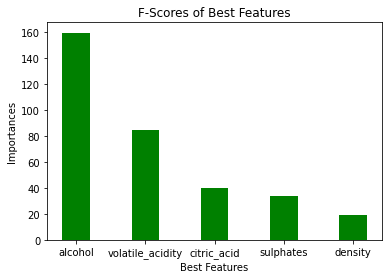

In [7]:
plt.bar(best, importances, color ='green',
        width = 0.4)
 
plt.xlabel("Best Features")
plt.ylabel("Importances")
plt.title("F-Scores of Best Features")
plt.show()

The above graph clearly indicates which features in the dataset have the closest relationship to the target.

### Model Fitting & Tuning <a id = 'fit'></a>
For the three different algorithms being tested the following are defined in the code. 
*  Cross validation method using 5 splits and 3 repeats 
*  The named classifier itself
*  Classifiers unique hyper-parameters
*  Final grid search function

The GaussianNB algorithm requires the further step of normalising the descriptive data through power transformation. This method assumes normal data, so transformation is necessary

Once these have been defined, queries can be run using the grid search functions to determine optimal parameters and the resulting accuracy score. 

Accuracy score shall remain the metric for determining the efficacy of models throughout this report.
At the bottom of each section shall be a visualisation demonstrating the performance of each hyper-parameter.



In [8]:
D_train, D_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size = 0.3,
                                                    random_state=999)

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

#### Decision Tree

In [10]:
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
             'min_samples_split': [2, 3, 5, 10]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(Data, target);

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


In [11]:
gs_DT.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3}

In [12]:
gs_DT.best_score_

0.8736566091954022

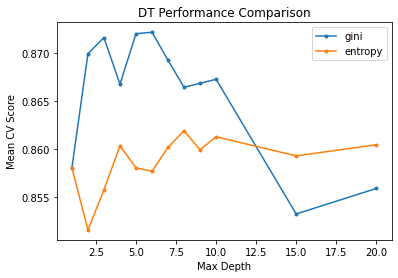

In [13]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']


for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

#### KNN Nearest Neigbours

In [14]:
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2]}

gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1, 
                      scoring='accuracy', 
                      return_train_score=True)

gs_KNN.fit(Data, target);

Fitting 15 folds for each of 14 candidates, totalling 210 fits


In [15]:
gs_KNN.best_params_

{'n_neighbors': 3, 'p': 2}

In [16]:
gs_KNN.best_score_

0.8784646029258099

In [17]:
gs_KNN.cv_results_['mean_test_score']

array([0.87220481, 0.87533242, 0.83614028, 0.83509274, 0.87054271,
       0.8784646 , 0.85178357, 0.85699843, 0.86908699, 0.87158634,
       0.85866575, 0.85469958, 0.86699974, 0.86595873])

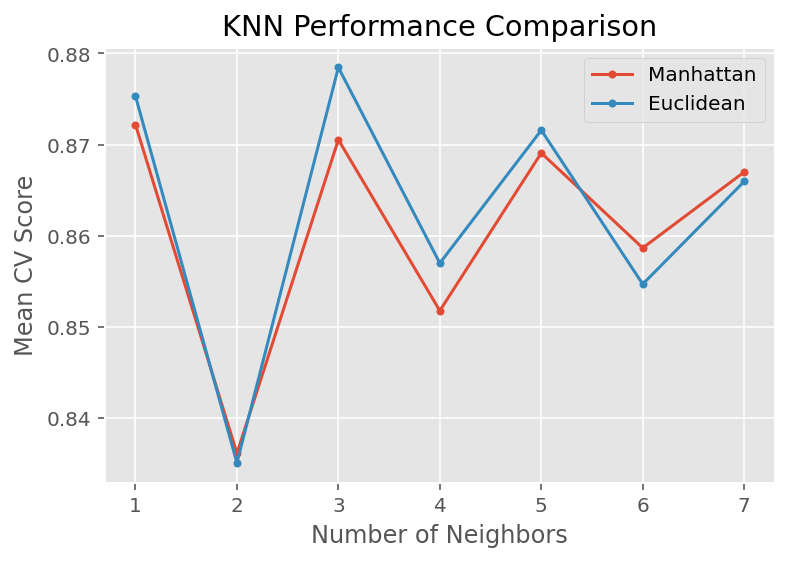

In [18]:
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2], ["Manhattan", "Euclidean"])


%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

for i in ["Manhattan", "Euclidean"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("KNN Performance Comparison")
plt.show()

#### Gaussian Naive Bayes

In [19]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(Data)

gs_NB.fit(Data_transformed, target);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [20]:
gs_NB.best_params_

{'var_smoothing': 0.657933224657568}

In [21]:
gs_NB.best_score_

0.867426854754441

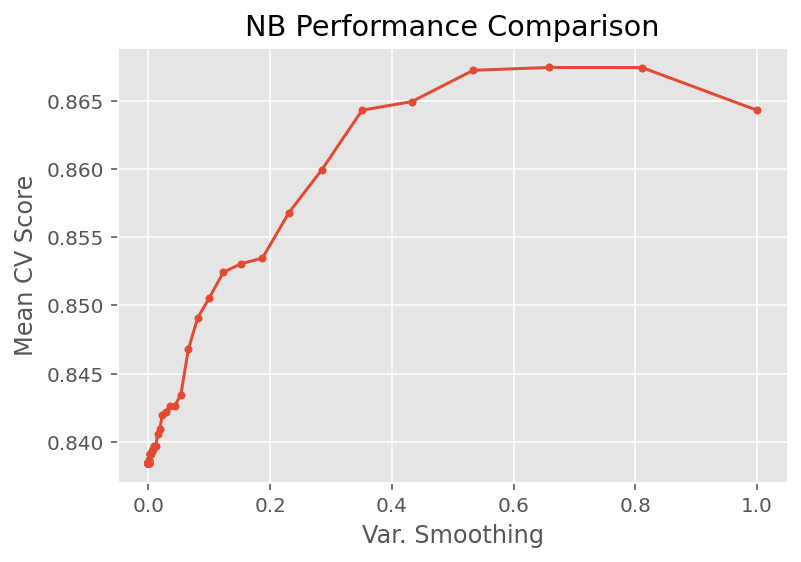

In [22]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()



### Model Comparison <a id = 'comparison'></a>
For comparison only the top 5 features, ranked by F score will be used instead of the whole dataset as above.

The below chunks include feature selection in the pipeline and include all the definitions outlined above in the fitting stage. Should these produce better results than the complete set they will be assessed against one another using paired t-tests.



In [23]:
params_pipe_KNN_fs = {'fselector__k': [5],
                      'knn__n_neighbors': [1, 2, 3, 4, 5],
                      'knn__p': [1, 2]}
 
pipe_KNN_fs = Pipeline([('fselector', SelectKBest(score_func=f_classif)), 
                        ('knn', KNeighborsClassifier())])

gs_pipe_KNN_fs = GridSearchCV(estimator=pipe_KNN_fs, 
                           param_grid=params_pipe_KNN_fs, 
                           cv=cv_method,
                           n_jobs=-2,
                           scoring='accuracy', 
                           verbose=1)

gs_pipe_KNN_fs.fit(Data, target);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


In [24]:
gs_pipe_KNN_fs.best_params_

{'fselector__k': 5, 'knn__n_neighbors': 3, 'knn__p': 2}

In [25]:
gs_KNN.best_score_ #best score using whole dataset

0.8784646029258099

In [26]:
gs_pipe_KNN_fs.best_score_ #best score feature selection

0.8695030041797281

In [27]:
params_pipe_DT_fs = {'fselector__k': [5],                  
                  'dt__criterion': ['gini', 'entropy'],
                  'dt__max_depth': [1, 2, 3, 4]}
 
pipe_DT_fs = Pipeline([('fselector', SelectKBest(score_func=f_classif)), 
                    ('dt', df_classifier)])

gs_pipe_DT_fs  = GridSearchCV(estimator=pipe_DT_fs, 
                           param_grid=params_pipe_DT_fs, 
                           cv=cv_method,
                           n_jobs=-2,
                           scoring='accuracy', 
                           verbose=1)

gs_pipe_DT_fs.fit(Data, target);

Fitting 15 folds for each of 8 candidates, totalling 120 fits


In [28]:
gs_pipe_DT_fs.best_params_

{'dt__criterion': 'gini', 'dt__max_depth': 2, 'fselector__k': 5}

In [29]:
gs_DT.best_score_ #best score whole dataset

0.8736566091954022

In [30]:
gs_pipe_DT_fs.best_score_ #best score feature selection

0.8699144461859979

In [31]:
params_pipe_NB_fs = {'fselector__k': [5],
                'nb__var_smoothing' : np.logspace(0,-9, num=100)
                    }
pipe_NB_fs = Pipeline([('fselector', SelectKBest(score_func=f_classif)), 
                        ('nb', nb_classifier)])

gs_pipe_NB_fs = GridSearchCV(estimator=pipe_NB_fs, 
                           param_grid=params_pipe_NB_fs, 
                           cv=cv_method,
                           n_jobs=-2,
                           scoring='accuracy', 
                           verbose=1)

gs_pipe_NB_fs.fit(Data_transformed, target);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [32]:
gs_pipe_NB_fs.best_params_

{'fselector__k': 5, 'nb__var_smoothing': 0.8111308307896871}

In [33]:
gs_NB.best_score_ #best score whole dataset

0.867426854754441

In [34]:
gs_pipe_NB_fs.best_score_ #best score feature selection

0.8709639498432601

Apart from the gaussianNB pipeline, better scores were found using the entire dataset than with feature selection, but only just. These differences could be attributed to the cross-validation process. The below chunks will run the pipelines again, this time with a different random state and 2 more repeats and the results shall be tested for statistical significance against each other. For the purposes of this test significance will be defined at 95%,

#### Paired T-Tests

In [35]:
cv_method_ttest = RepeatedStratifiedKFold(n_splits=5, 
                                          n_repeats=5, 
                                          random_state=123)

In [36]:
cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN_fs.best_estimator_,
                                 X=Data,
                                 y=target, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='accuracy')
cv_results_KNN.mean().round(3)

0.871

In [37]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT_fs.best_estimator_,
                                X=Data,
                                y=target, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_DT.mean().round(3)

0.87

In [38]:
cv_results_NB = cross_val_score(estimator=gs_pipe_NB_fs.best_estimator_,
                                 X=Data_transformed,
                                 y=target, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='accuracy')
cv_results_NB.mean().round(3)

0.867

Result of comparison between KNN and DT

In [39]:
print(stats.ttest_rel(cv_results_DT, cv_results_KNN).pvalue.round(3))

0.88


Result of comparison netween kNN and NB

In [40]:
print(stats.ttest_rel(cv_results_NB, cv_results_KNN).pvalue.round(3))

0.293


Result of comparison between NB and DT

In [41]:
print(stats.ttest_rel(cv_results_NB, cv_results_DT).pvalue.round(3))

0.272


Here it can be seen that none of our comparisons are statistaticly significant as they all score above 0.05. This means that there is insuffiecient proof to reject the null hypothesis indicating that the percieved differences are the product of chance.

## Critique & Limitations <a id = 'critique'></a>
Initial attempts at this project involved using all values in the target variable, binning these six categories into two separate, but more meaningful categories demonstrated how important it is to set and know your goals first! The failure to adequately plan likely cost many hours but resulted in a refocus that yielded much higher accuracy scores in the end. Working with a binary classifier is also much simpler than a classifier with six levels, the product of a ML project needs to be meaningful and designing a wine to score a 3 in quality is not particularly meaningful, get rid of the levels and just have 'Good' and "Bad'.

Reading the report for which the dataset was originally created (Cortez, P., 2009) revealed how important feature selection was. This project initially discarded feature selection in favour of using the entire set, this was because phase 1 visualisations did not reveal meaningful correlations e.g., The strong relationship between alcohol and quality was dismissed as one couldn't just keep adding more alcohol to a bottle to make it better, at some point it would stop being wine! Furthermore, the original report uses a much more sophisticated feature selection technique than this report, and consequentially received different results. This signals that the approach used here should have focused more on that aspect instead of just using the whole dataset because it had so few variables.


## Summary & Conclusions <a id = 'con'></a>

### Project Summary <a id = 'PS'></a>

The initial phase of this project began with the selection of a dataset that was close to my own working experience. Being able to predict the quality of a product before it is exposed to the market is extremely beneficial, more so with consumables that prioritise a specific flavour profile. To be able to predict how a product will perform by comparing it to others within a similar rating or category can save a lot of money and place you in a much better position from which to enter any market. 

Once the dataset was selected, I outlined my goals and selected the target variable, which in the beginning was ‘quality’. Later in phase 2 this would change, and the target variable would be transformed from this variable instead as it contained many levels that were not helpful. The dataset was clean and contained no null values or special characters etc… and all numeric values were consistent and made logical sense.

Visualising the data was the next step. Using python libraries such as matplotlib and seaborn I was able to detect several relationships between the different variables and the target but also between the different descriptors as well. It was important that all relationships made sense e.g., as citric acidity rose pH levels should fall, as alcohol rose so should density and so on. Using a seaborn pair plot allowed me to see these relationships clearly and this gave me confidence that this project could yield meaningful results as the data was not random and indeed reflective of real-world chemical analysis. The plots specifically revealed relationships between acidity and alcohol content as they pertain to lower quality wines when these levels are lowest, this relationship was confirmed during formal feature selection in phase 2.

In phase 2 some further processing was performed to transform the target variable into a binary class, then the descriptive features were scaled, and the target feature converted to numeric type to facilitate the algorithms being used. Feature selection involved the ranking of the top 5 features in the set based on F-score, these results confirmed the strong relationship between the alcohol and acidity variables and the target. During the initial fitting and tuning phase however, the entire dataset was used.

For fitting and tuning I applied three different algorithms. These were decision trees, k nearest neighbours and gaussian naïve bayes, using the accuracy metric on all three. After this process I performed paired t-tests (this time using the top 5 selected features as part of a pipeline) to both determine the highest performing algorithm and ensure their performance was statistically sound and not the products of random chance.


### Summary of Findings <a id = 'find'></a>

Overall, each algorithm returned very similar results at around 87% either with or without feature selection with only KNN performing higher on the whole dataset with nearly 88% accuracy where k= 3 using Euclidean distance, however after further refinement and paired t-tests it was discovered that the difference in the results was likely due to chance.

That said it would make sense for KNN to work best in what is essentially a subjective assessment of wine flavour, bottles containing similar chemical quantities would clump together in the feature space making a newcomer’s position in that space significant.


### Conclusions <a id = 'cons'></a>
It is safe to conclude that predictive modelling on this type of problem is a worthy pursuit, even when performed by a beginner analyst. These algorithms prove powerful in predicting the quality of red wine based on the objective and quantifiable characteristics present in the beverage and even at an accuracy only in the high eighties these results would aid merchants and vintners greatly in selecting what wines should go to market.

In short, I was able to both predict the quality of red wine, as defined between the two categories of High and low quality and I was able to recognise the key features that determine that out come through the feature selection processes outlined above. Both goals have been achieved.



## References <a id = 'references'></a>

Boulton, R. B., Singleton, V. L., Bisson, L. F., & Kunkee, R. E. (2013). Principles and practices of winemaking. Springer Science & Business Media.

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553.